## Available:
1. black list: wont change the black listed columns
2. early stopping
3. one hot encoded inputs
4. Correct Black list, now it is applied on the one_hot list not the input columns. 

## TODO:
1. The node labels are out of the figure

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import pickle

In [3]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(555)

import matplotlib.pyplot
plt.style.use('ggplot')

In [4]:
from alibi.utils.mapping import (
    ohe_to_ord as alibi_ohe_to_ord,
    ord_to_ohe as alibi_ord_to_ohe,
)

In [5]:
from ga_attack_gibss import plot_graph, create_onehot_map, GA_Counterfactual, alibi_ord_to_ohe, GAdvExample

In [6]:
data = pd.read_csv('german_credit.csv')
y = data['default']
X_df = data.drop('default', axis=1)

cats = [X_df.dtypes.index[i] for i in range(X_df.shape[1]) if X_df.dtypes[i]=='object']
X_df = pd.get_dummies(X_df, columns=cats)

X = X_df.values
y = y.values

X_df.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes
0,6,1169,4,4,67,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1
1,48,5951,2,2,22,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2,12,2096,2,3,49,1,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1
3,42,7882,2,4,45,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1
4,24,4870,3,4,53,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1


In [22]:
X.shape

(1000, 61)

In [7]:
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

# logistic = SGDClassifier(loss='log', penalty='l1', early_stopping=True,
#                          max_iter=10000, tol=1e-5, random_state=0)
# sca = MinMaxScaler()
# clf = Pipeline(steps=[('sca', sca), ('logistic', logistic)])
# clf.fit(X,y)
# clf.score(X,y)

0.775

In [8]:
feature_names = list(X_df.columns)

In [9]:
_, one_hot = create_onehot_map(feature_names, sep="_", min_dist=1, data=None)
one_hot

{7: 4,
 11: 5,
 16: 10,
 26: 5,
 31: 5,
 36: 4,
 40: 3,
 43: 4,
 47: 3,
 50: 3,
 53: 4,
 57: 2,
 59: 2}

In [10]:
data_ = alibi_ohe_to_ord(X_train, one_hot)[0]
data_.shape, X_train.shape

((600, 20), (600, 61))

In [11]:
np.quantile(data_[:,0], np.linspace(0,1,5))

array([ 4., 12., 18., 24., 72.])

In [12]:
indp = np.where((clf.predict_proba(X_test)[:,1]<0.5) & (clf.predict_proba(X_test)[:,1]>0.4))
indp

(array([ 10,  13,  21,  25,  37,  57,  59,  66,  73,  83,  86, 112, 117,
        119, 123, 127, 134, 136, 145, 151, 172, 174, 180, 181, 198, 202,
        211, 213, 214, 226, 227, 238, 244, 247, 250, 252, 269, 281, 286,
        293, 304, 311, 316, 326, 336, 338, 346, 360, 383, 386, 394]),)

In [13]:
indn = np.where((clf.predict_proba(X_test)[:,1]<0.7) & (clf.predict_proba(X_test)[:,1]>0.5))
indn

(array([  9,  11,  16,  18,  29,  44,  51,  52,  55,  64,  65,  68,  71,
         72,  74,  75,  76,  79,  80,  81,  94, 106, 108, 114, 131, 132,
        141, 150, 152, 162, 164, 171, 173, 193, 209, 210, 212, 224, 232,
        236, 243, 245, 257, 261, 266, 270, 271, 273, 279, 303, 306, 307,
        314, 315, 324, 327, 329, 350, 357, 361, 362, 370, 372, 378, 380]),)

In [14]:
idx_test = 315

ga = GAdvExample(feature_names=feature_names,
                sol_per_pop=30, num_parents_mating=15, cat_vars_ohe=one_hot,
                 num_generations=100, n_runs=10, black_list=None,
                 verbose=False, beta=.96)

x_all, x_changes, x_sucess = ga.attack(clf, x=X_test[idx_test,:],x_train=X_train)

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


In [15]:
ga.results

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes,P0,P1
0,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.370000,0.630000
1,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.570000,0.430000
2,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.600000,0.400000
7,48.000000,6110.000000,2.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000

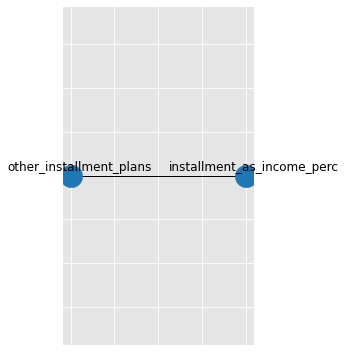

In [16]:
plot_graph(x_changes, 0)

In [23]:
testing = []
ga = GAdvExample(feature_names=feature_names,
                sol_per_pop=35, num_parents_mating=15, cat_vars_ohe=one_hot,
                 num_generations=200, n_runs=2, black_list=None,
                 verbose=False, beta=.96)
for it, sample in enumerate(X_test[np.c_[indp, indn][0]]):
    try:
        x_all, x_changes, x_sucess = ga.attack(clf, x=sample,x_train=X_train)
        for xi in x_sucess:
            testing.append((sample, xi))
        print(it, len(x_sucess))
    except:
        pass

  0%|          | 0/2 [00:00<?, ?it/s]

0 2


  0%|          | 0/2 [00:00<?, ?it/s]

1 2


  0%|          | 0/2 [00:00<?, ?it/s]

2 2


  0%|          | 0/2 [00:00<?, ?it/s]

3 2


  0%|          | 0/2 [00:00<?, ?it/s]

4 2


  0%|          | 0/2 [00:00<?, ?it/s]

5 2


  0%|          | 0/2 [00:00<?, ?it/s]

6 2


  0%|          | 0/2 [00:00<?, ?it/s]

7 2


  0%|          | 0/2 [00:00<?, ?it/s]

8 2


  0%|          | 0/2 [00:00<?, ?it/s]

9 2


  0%|          | 0/2 [00:00<?, ?it/s]

10 2


  0%|          | 0/2 [00:00<?, ?it/s]

11 2


  0%|          | 0/2 [00:00<?, ?it/s]

12 2


  0%|          | 0/2 [00:00<?, ?it/s]

13 2


  0%|          | 0/2 [00:00<?, ?it/s]

14 2


  0%|          | 0/2 [00:00<?, ?it/s]

15 2


  0%|          | 0/2 [00:00<?, ?it/s]

16 2


  0%|          | 0/2 [00:00<?, ?it/s]

17 2


  0%|          | 0/2 [00:00<?, ?it/s]

18 2


  0%|          | 0/2 [00:00<?, ?it/s]

19 2


  0%|          | 0/2 [00:00<?, ?it/s]

20 2


  0%|          | 0/2 [00:00<?, ?it/s]

21 2


  0%|          | 0/2 [00:00<?, ?it/s]

22 2


  0%|          | 0/2 [00:00<?, ?it/s]

23 2


  0%|          | 0/2 [00:00<?, ?it/s]

24 2


  0%|          | 0/2 [00:00<?, ?it/s]

25 2


  0%|          | 0/2 [00:00<?, ?it/s]

26 2


  0%|          | 0/2 [00:00<?, ?it/s]

27 2


  0%|          | 0/2 [00:00<?, ?it/s]

28 2


  0%|          | 0/2 [00:00<?, ?it/s]

29 2


  0%|          | 0/2 [00:00<?, ?it/s]

30 2


  0%|          | 0/2 [00:00<?, ?it/s]

31 2


  0%|          | 0/2 [00:00<?, ?it/s]

32 2


  0%|          | 0/2 [00:00<?, ?it/s]

33 2


  0%|          | 0/2 [00:00<?, ?it/s]

34 2


  0%|          | 0/2 [00:00<?, ?it/s]

35 2


  0%|          | 0/2 [00:00<?, ?it/s]

36 2


  0%|          | 0/2 [00:00<?, ?it/s]

37 2


  0%|          | 0/2 [00:00<?, ?it/s]

38 2


  0%|          | 0/2 [00:00<?, ?it/s]

39 2


  0%|          | 0/2 [00:00<?, ?it/s]

40 2


  0%|          | 0/2 [00:00<?, ?it/s]

41 2


  0%|          | 0/2 [00:00<?, ?it/s]

42 2


  0%|          | 0/2 [00:00<?, ?it/s]

43 2


  0%|          | 0/2 [00:00<?, ?it/s]

44 2


  0%|          | 0/2 [00:00<?, ?it/s]

45 2


  0%|          | 0/2 [00:00<?, ?it/s]

46 2


  0%|          | 0/2 [00:00<?, ?it/s]

47 2


  0%|          | 0/2 [00:00<?, ?it/s]

48 2


  0%|          | 0/2 [00:00<?, ?it/s]

49 2


  0%|          | 0/2 [00:00<?, ?it/s]

50 2


  0%|          | 0/2 [00:00<?, ?it/s]

51 2


  0%|          | 0/2 [00:00<?, ?it/s]

52 2


  0%|          | 0/2 [00:00<?, ?it/s]

53 2


  0%|          | 0/2 [00:00<?, ?it/s]

54 2


  0%|          | 0/2 [00:00<?, ?it/s]

55 2


  0%|          | 0/2 [00:00<?, ?it/s]

56 2


  0%|          | 0/2 [00:00<?, ?it/s]

57 2


  0%|          | 0/2 [00:00<?, ?it/s]

58 2


  0%|          | 0/2 [00:00<?, ?it/s]

59 2


  0%|          | 0/2 [00:00<?, ?it/s]

60 2


  0%|          | 0/2 [00:00<?, ?it/s]

61 2


  0%|          | 0/2 [00:00<?, ?it/s]

62 2


  0%|          | 0/2 [00:00<?, ?it/s]

63 2


  0%|          | 0/2 [00:00<?, ?it/s]

64 2


  0%|          | 0/2 [00:00<?, ?it/s]

65 2


  0%|          | 0/2 [00:00<?, ?it/s]

66 2


  0%|          | 0/2 [00:00<?, ?it/s]

67 2


  0%|          | 0/2 [00:00<?, ?it/s]

68 2


  0%|          | 0/2 [00:00<?, ?it/s]

69 2


  0%|          | 0/2 [00:00<?, ?it/s]

70 2


  0%|          | 0/2 [00:00<?, ?it/s]

71 2


  0%|          | 0/2 [00:00<?, ?it/s]

72 2


  0%|          | 0/2 [00:00<?, ?it/s]

73 2


  0%|          | 0/2 [00:00<?, ?it/s]

74 2


  0%|          | 0/2 [00:00<?, ?it/s]

75 2


  0%|          | 0/2 [00:00<?, ?it/s]

76 2


  0%|          | 0/2 [00:00<?, ?it/s]

77 2


  0%|          | 0/2 [00:00<?, ?it/s]

78 2


  0%|          | 0/2 [00:00<?, ?it/s]

79 2


  0%|          | 0/2 [00:00<?, ?it/s]

80 2


  0%|          | 0/2 [00:00<?, ?it/s]

81 2


  0%|          | 0/2 [00:00<?, ?it/s]

82 2


  0%|          | 0/2 [00:00<?, ?it/s]

83 2


  0%|          | 0/2 [00:00<?, ?it/s]

84 2


  0%|          | 0/2 [00:00<?, ?it/s]

85 2


  0%|          | 0/2 [00:00<?, ?it/s]

86 2


  0%|          | 0/2 [00:00<?, ?it/s]

87 2


  0%|          | 0/2 [00:00<?, ?it/s]

88 2


  0%|          | 0/2 [00:00<?, ?it/s]

89 2


  0%|          | 0/2 [00:00<?, ?it/s]

90 2


  0%|          | 0/2 [00:00<?, ?it/s]

91 2


  0%|          | 0/2 [00:00<?, ?it/s]

92 2


  0%|          | 0/2 [00:00<?, ?it/s]

93 2


  0%|          | 0/2 [00:00<?, ?it/s]

94 2


  0%|          | 0/2 [00:00<?, ?it/s]

95 2


  0%|          | 0/2 [00:00<?, ?it/s]

96 2


  0%|          | 0/2 [00:00<?, ?it/s]

97 2


  0%|          | 0/2 [00:00<?, ?it/s]

98 2


  0%|          | 0/2 [00:00<?, ?it/s]

99 2


  0%|          | 0/2 [00:00<?, ?it/s]

100 2


  0%|          | 0/2 [00:00<?, ?it/s]

101 2


  0%|          | 0/2 [00:00<?, ?it/s]

102 2


  0%|          | 0/2 [00:00<?, ?it/s]

103 2


  0%|          | 0/2 [00:00<?, ?it/s]

104 2


  0%|          | 0/2 [00:00<?, ?it/s]

106 2


  0%|          | 0/2 [00:00<?, ?it/s]

107 2


  0%|          | 0/2 [00:00<?, ?it/s]

108 2


  0%|          | 0/2 [00:00<?, ?it/s]

109 2


  0%|          | 0/2 [00:00<?, ?it/s]

110 2


  0%|          | 0/2 [00:00<?, ?it/s]

111 2


  0%|          | 0/2 [00:00<?, ?it/s]

112 2


  0%|          | 0/2 [00:00<?, ?it/s]

113 2


  0%|          | 0/2 [00:00<?, ?it/s]

114 2


100%|██████████| 2/2 [00:10<00:00,  5.09s/it]

115 2


In [24]:
pickle.dump(testing, open("testing_gb_4p.pkl", "wb"))

In [25]:
len(testing)

230

# Titanic

In [ ]:
data = pd.read_csv('titanic.csv')
data.head()

In [ ]:
# from sklearn.datasets import load_breast_cancer
# X,y = load_breast_cancer(True)
# data = data.drop(['Name','Ticket','Cabin','Embarked','PassengerId'],axis=1)

data = data.drop(['Name'], axis=1)
data = data.dropna()
X_df = data.drop(['Survived'],axis=1)
y = data['Survived']

for d in X_df.columns[X_df.dtypes=='O']:
    le = LabelEncoder()    
    X_df[d] = le.fit_transform(X_df[d])
    print(d," .....   ",le.classes_)

X = X_df.values
y = y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
clf_titanic = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [ ]:
idx_test = 5

ga_titanic = GAdvExample(feature_names=list(X_df.columns),
                sol_per_pop=30, num_parents_mating=10, cat_vars_ohe=None,
                 num_generations=100, n_runs=10, black_list=[],
                 verbose=False, beta=.9)

x_all, x_changes, x_sucess = ga_titanic.attack(clf_titanic, x=X_test[idx_test,:],x_train=X_train)

In [ ]:
ga_titanic.results